In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import pickle
import torch
import lightning

from mlcolvar.cvs import BaseCV
from mlcolvar.core import FeedForward, Normalization
from mlcolvar.core.transform import Statistics, Transform

from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from itertools import combinations

np.bool = np.bool_

CUDA_DEVICE = 7
blue = (70 / 255, 110 / 255, 250 / 255)

# INPUT_DIM = 45
# MLCV_DIM = 1
# dim_normalization = False
# # date = "0811_162324"
# date = "0811_162309"
# molecule = "CLN025"

MLCV_DIM = 1
INPUT_DIM = 190
molecule = "2JOF"
date = "0812_125552"
dim_normalization = False

save_path  = f"/home/shpark/prj-mlcv/lib/bioemu/model/{date}/mlcv_model.pt"

# Load

In [2]:
# Model class definition

class DIM_NORMALIZATION(Transform):
    def __init__(
        self,
        feature_dim = 1
    ):
        super().__init__(in_features=feature_dim, out_features=feature_dim)
        self.register_buffer("feature_dim", torch.tensor(feature_dim))
        
    def forward(self, x):
        x = torch.nn.functional.normalize(x, dim=-1)
        return x

class MLCV(BaseCV, lightning.LightningModule):
    BLOCKS = ["norm_in", "encoder",]

    def __init__(
        self,
        mlcv_dim: int,
        encoder_layers: list,
        dim_normalization: bool = False,
        options: dict = None,
        **kwargs,
    ):
        super().__init__(in_features=encoder_layers[0], out_features=encoder_layers[-1], **kwargs)
        # ======= OPTIONS =======
        options = self.parse_options(options)
        
        # ======= BLOCKS =======
        # initialize norm_in
        o = "norm_in"
        if (options[o] is not False) and (options[o] is not None):
            self.norm_in = Normalization(self.in_features, **options[o])

        # initialize encoder
        o = "encoder"
        self.encoder = FeedForward(encoder_layers, **options[o])
        if dim_normalization:
        	self.postprocessing = DIM_NORMALIZATION(mlcv_dim)


In [3]:
# Load model

model_state = torch.load(save_path)
print(model_state.keys())

mlcv_state_dict = model_state["mlcv_state_dict"]
encoder_layers = [INPUT_DIM, 100, 100, MLCV_DIM]
options = {
	"encoder": {
		"activation": "tanh",
		"dropout": [0.1, 0.1, 0.1]
	},
	"norm_in": {
	},
}
mlcv_model = MLCV(
    mlcv_dim = MLCV_DIM,
	encoder_layers = encoder_layers,
	dim_normalization = dim_normalization,
	options = options
)

mlcv_model.load_state_dict(mlcv_state_dict)
mlcv_model.eval()
print(mlcv_model)

dict_keys(['mlcv_state_dict'])
MLCV(
  (norm_in): Normalization(in_features=190, out_features=190, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=190, out_features=100, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Dropout(p=0.1, inplace=False)
    )
  )
)


In [4]:
# TICA Model
lag = 5

class TICA_WRAPPER():
	def __init__(
		self,
		pdb_path,
		tica_model_path,
		tica_switch_model_path = None,
	):
		super().__init__()
		with open(tica_model_path, 'rb') as f:
			tica_model = pickle.load(f)
		self.tica_model = tica_model
		if tica_switch_model_path is not None:
			with open(tica_switch_model_path, 'rb') as f:
				tica_switch_model = pickle.load(f)
			self.tica_switch_model = tica_switch_model
		self.pdb = md.load(pdb_path)
		self.ca_resid_pair = np.array(
			[(a.index, b.index) for a, b in combinations(list(self.pdb.topology.residues), 2)]
		)
  
		print(self.tica_model)

	def transform(
		self,
		cad_data: np.ndarray,
		switch: bool = False,
	):
		if switch:
			feature_distance_switch = (1 - np.power(cad_data / 0.8, 6)) / (1 - np.power(cad_data / 0.8, 12))
			tica_coord = self.tica_switch_model.transform(feature_distance_switch)
		else:
			tica_coord = self.tica_model.transform(cad_data)
		
		return tica_coord

	def pos2cad(
		self,
		pos_data: np.ndarray,
	):
		self.pdb.xyz = pos_data
		ca_pair_distances, _ = md.compute_contacts(
			self.pdb, scheme="ca", contacts=self.ca_resid_pair, periodic=False
		)
		return ca_pair_distances

tica_wrapper = TICA_WRAPPER(
	tica_model_path=f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_lag{lag}.pkl",
	# tica_switch_model_path=f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl",
	pdb_path=f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb",
)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=5,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


In [5]:
# Committor model

committor_path = "./committor.pt"
committor_model = torch.jit.load(committor_path, map_location=f"cuda:{CUDA_DEVICE}")
print(committor_model)

RecursiveScriptModule(
  original_name=NN_committor_guess
  (nn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Tanh)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=Tanh)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=CustomActivation)
  )
)


In [7]:
# Load position data
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"

pos_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/pos.pt"
cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/cad.pt"
pos_torch = torch.load(pos_path)
cad_torch = torch.load(cad_path)
print(f"Position shape: {pos_torch.shape}")
print(f"CAD shape: {cad_torch.shape}")

if molecule == "CLN025":
	bond_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/bond_num_distance_angle.pt"
	label_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/label_distance_angle.pt"
	bond_torch = torch.load(bond_path)
	label_torch = torch.load(label_path)
	print(bond_torch.shape)
	print(label_torch.shape)

Position shape: torch.Size([530000, 272, 3])
CAD shape: torch.Size([530000, 190])


# Analysis

In [13]:
cad_data = cad_torch.numpy()
cv = mlcv_model(torch.from_numpy(cad_data))
cv = cv.detach().cpu().numpy()

print(cv.shape)
print(cv.max(), cv.min())
MLCV_DIM = cv.shape[1]

(530000, 1)
10.349826 -10.108323


In [ ]:
cv_normalized = np.zeros_like(cv)

for cv_dim in range(MLCV_DIM):
	cv_dim_val = cv[:, cv_dim]
	cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
	cv_range_mean = (cv_range_min + cv_range_max) / 2.0
	cv_range = (cv_range_max - cv_range_min) / 2.0
	cv_normalized[:, cv_dim] = (cv_dim_val - cv_range_mean) / cv_range

	print(f"< CV {cv_dim} >")
	print(f"  range_min: {cv_range_min:.4f}")
	print(f"  range_max: {cv_range_max:.4f}")
	print(f"  range_mean: {cv_range_mean:.4f}")

cv = cv_normalized

for cv_dim in range(MLCV_DIM):
	cv_dim_val = cv[:, cv_dim]
	cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
	cv_range_mean = (cv_range_min + cv_range_max) / 2.0
	cv_range = (cv_range_max - cv_range_min) / 2.0
	print(f"< Normalized CV {cv_dim} >")
	print(f"  range_min: {cv_range_min:.4f}")
	print(f"  range_max: {cv_range_max:.4f}")
	print(f"  range_mean: {cv_range_mean:.4f}")

< CV 0 >
  range_min: -10.1083
  range_max: 10.3498
  range_mean: 0.1208


In [28]:
cv = -cv

## TICA and CVs

In [21]:
# 2D TICA coordinates
tica_data = tica_wrapper.transform(cad_data, switch=False)
x = tica_data[:, 0]
y = tica_data[:, 1]

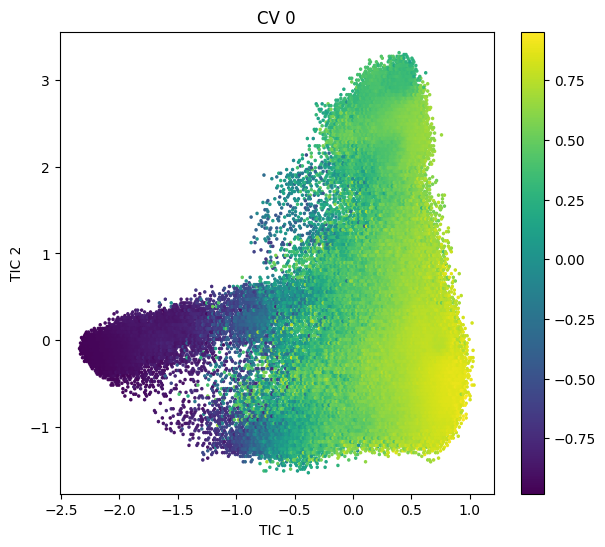

In [22]:
# 2D TICA plot
for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	hb = ax.hexbin(
		x, y, C=cv[:, cv_dim],
		gridsize=200,                     # controls resolution
		reduce_C_function=np.mean,       # compute average per hexagon
		cmap='viridis',                  # colormap
	)
	plt.colorbar(hb)
	plt.xlabel("TIC 1")
	plt.ylabel("TIC 2")
	plt.title(f"CV {cv_dim}")
	plt.savefig(f"/home/shpark/prj-mlcv/lib/bioemu/model/{date}/tica-cv{cv_dim}.png")
	plt.show()

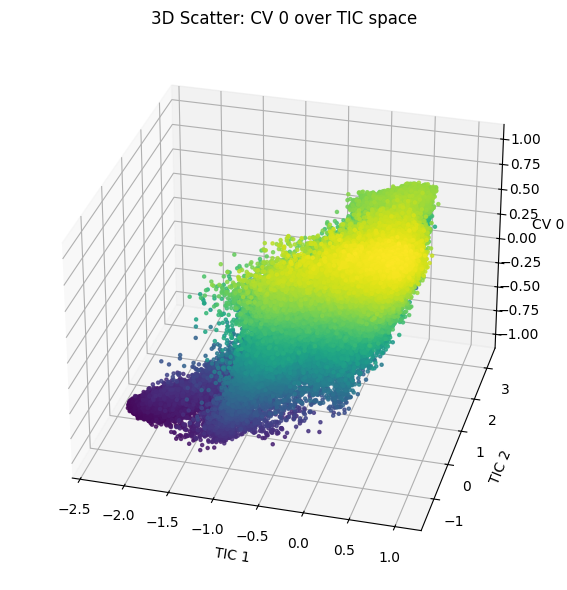

In [23]:
# 3D scatter plot
for cv_dim in range(MLCV_DIM):
	z = cv[:, cv_dim]

	fig = plt.figure(figsize=(8, 6))
	ax = fig.add_subplot(111, projection='3d')

	sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=5, alpha=0.8)

	ax.set_xlabel('TIC 1')
	ax.set_ylabel('TIC 2')
	ax.set_zlabel(f'CV {cv_dim}')
	ax.set_title(f'3D Scatter: CV {cv_dim} over TIC space')
	ax.view_init(azim=-75)
	# fig.colorbar(sc, ax=ax, label='CV Value')

	plt.tight_layout()
	plt.show()

In [32]:
# Interactive 3D TICA plot

# # Loop over each CV dimension
# for cv_dim in range(MLCV_DIM):
#     z = cv[:, cv_dim]

#     fig = go.Figure(
#         data=go.Scatter3d(
#             x=x,
#             y=y,
#             z=z,
#             mode='markers',
#             marker=dict(
#                 size=3,
#                 color=z,
#                 colorscale='Viridis',
#                 colorbar=dict(title=f'CV {cv_dim}'),
#                 opacity=0.8
#             )
#         )
#     )

#     fig.update_layout(
#         scene=dict(
#             xaxis_title='TIC 1',
#             yaxis_title='TIC 2',
#             zaxis_title=f'CV {cv_dim}',
# 			aspectmode='manual',
#         	aspectratio=dict(x=1, y=1, z=1)
#         ),
#         title=f'CV {cv_dim} in TICA Space',
#         margin=dict(l=0, r=0, b=0, t=30)
#     )

#     fig.show()

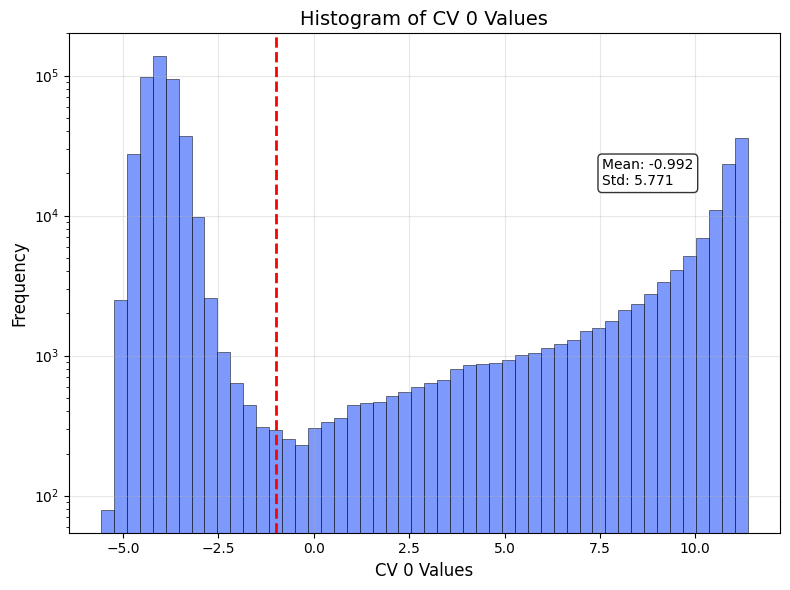

CV 0 Statistics:
  Total samples: 530000
  Mean: -0.992252
  Standard deviation: 5.770572


In [33]:
n_bins = 50

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
counts, bins, patches = ax.hist(
    cv_dim_val,
    bins=n_bins,
    alpha=0.7,
    color=blue,
    edgecolor='black',
    linewidth=0.5,
    log=True,
)

# Add statistics text
mean_val = np.mean(cv_dim_val)
std_val = np.std(cv_dim_val)
min_val = np.min(cv_dim_val)
max_val = np.max(cv_dim_val)

stats_text = f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}'
ax.text(0.75, 0.75, stats_text, transform=ax.transAxes, 
		bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
		verticalalignment='top', fontsize=10)
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')

ax.set_xlabel(f'CV {cv_dim} Values', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'Histogram of CV {cv_dim} Values', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"CV {cv_dim} Statistics:")
print(f"  Total samples: {len(cv_dim_val)}")
print(f"  Mean: {mean_val:.6f}")
print(f"  Standard deviation: {std_val:.6f}")

## Bond number and CVs

In [34]:
# Load foldeness data

def foldedness_by_hbond(
    traj,
    distance_cutoff=0.35,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int) 
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff)).astype(int)

	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + label_ASP3N_TYR8O + label_THR6OG1_ASP3O \
		+ label_THR6N_ASP3OD1 + label_THR6N_ASP3OD2 + label_GLY7N_ASP3O + label_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	return labels, bond_sum

dummy_pdb = tica_wrapper.pdb
dummy_pdb.xyz = pos_torch.numpy()
label, bond_num = foldedness_by_hbond(dummy_pdb)

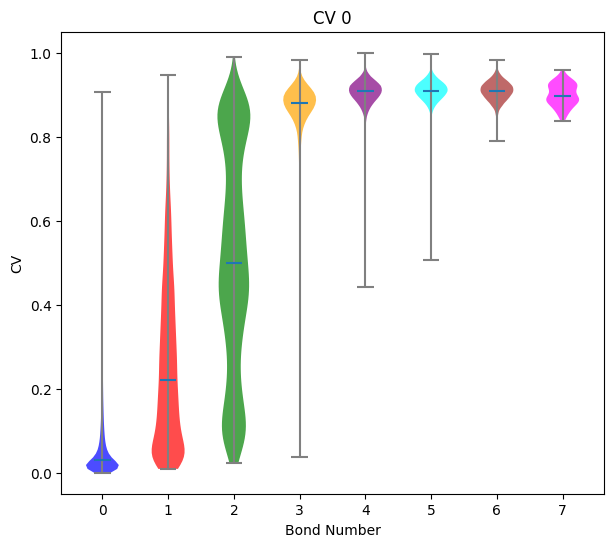

In [39]:
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'brown', 'magenta']

for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	cv_dim_val = cv[:, cv_dim]
	range_min, range_max = cv_dim_val.min(), cv_dim_val.max()
	x = (cv_dim_val - range_min) / (range_max - range_min)
	y = bond_num
	grouped = [x[y == i] for i in sorted(np.unique(y))]
	violin = plt.violinplot(grouped, positions=sorted(np.unique(y)), showmeans=False, showmedians=True)
	for i, body in enumerate(violin['bodies']):
		body.set_facecolor(colors[i % len(colors)])
		body.set_alpha(0.7)

	violin['cbars'].set_edgecolor('gray')
	violin['cmaxes'].set_edgecolor('gray')
	violin['cmins'].set_edgecolor('gray')

	ax.set_xlabel("Bond Number")
	ax.set_ylabel("CV")
	ax.set_title(f"CV {cv_dim}")
	plt.show()


## Committor and CVs

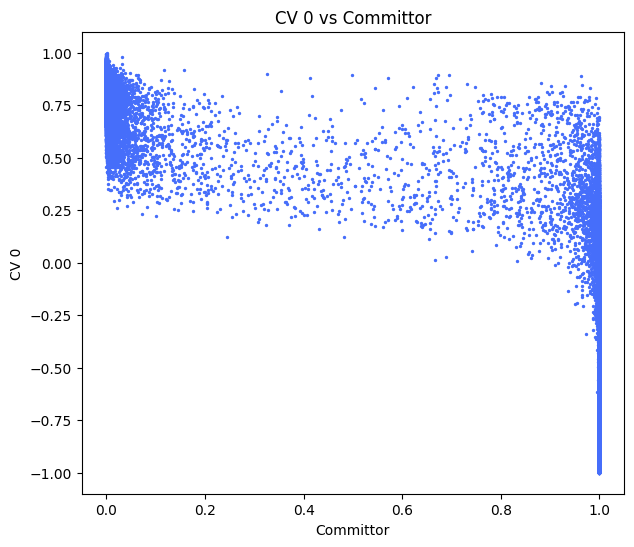

In [40]:
committor_value = committor_model(cad_torch.to(CUDA_DEVICE))
committor_value = committor_value.cpu().detach().numpy().flatten()


for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	ax.scatter(committor_value, cv[:, cv_dim], color=blue, s=2)
	ax.set_xlabel("Committor")
	ax.set_ylabel(f"CV {cv_dim}")
	ax.set_title(f"CV {cv_dim} vs Committor")
	plt.show()

In [ ]:
# Pearson correlation between committor values and CV values
from scipy.stats import pearsonr
import pandas as pd

print("Pearson Correlation Analysis")
print("=" * 50)

# Compute correlations for each CV dimension
correlation_results = []

for cv_dim in range(MLCV_DIM):
    cv_values = cv[:, cv_dim]
    
    # Compute Pearson correlation
    correlation, p_value = pearsonr(committor_value, cv_values)
    
    correlation_results.append({
        'CV_Dimension': cv_dim,
        'Correlation': correlation,
        'P_Value': p_value,
        'Correlation_Strength': 'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.3 else 'Weak'
    })
    
    print(f"CV {cv_dim} vs Committor:")
    print(f"  Pearson correlation: {correlation:.6f}")
    print(f"  P-value: {p_value:.2e}")
    print(f"  Correlation strength: {correlation_results[-1]['Correlation_Strength']}")
    print()

# Create a summary DataFrame
df_correlations = pd.DataFrame(correlation_results)
print("Summary Table:")
print(df_correlations.to_string(index=False))

# Additional correlations with other variables
print("\n" + "=" * 50)
print("Additional Correlations")
print("=" * 50)

# Correlation with TICA coordinates
tica_x = tica_data[:, 0]
tica_y = tica_data[:, 1]

corr_tica_x, p_tica_x = pearsonr(committor_value, tica_x)
corr_tica_y, p_tica_y = pearsonr(committor_value, tica_y)

print(f"Committor vs TICA-1: r = {corr_tica_x:.6f}, p = {p_tica_x:.2e}")
print(f"Committor vs TICA-2: r = {corr_tica_y:.6f}, p = {p_tica_y:.2e}")

# Correlation with bond number
corr_bond, p_bond = pearsonr(committor_value, bond_num)
print(f"Committor vs Bond Number: r = {corr_bond:.6f}, p = {p_bond:.2e}")

# Cross-correlations between variables
print(f"\nCross-correlations:")
for cv_dim in range(MLCV_DIM):
    cv_values = cv[:, cv_dim]
    corr_cv_tica1, p_cv_tica1 = pearsonr(cv_values, tica_x)
    corr_cv_tica2, p_cv_tica2 = pearsonr(cv_values, tica_y)
    corr_cv_bond, p_cv_bond = pearsonr(cv_values, bond_num)
    
    print(f"CV {cv_dim} vs TICA-1: r = {corr_cv_tica1:.6f}")
    print(f"CV {cv_dim} vs TICA-2: r = {corr_cv_tica2:.6f}")
    print(f"CV {cv_dim} vs Bond Number: r = {corr_cv_bond:.6f}")
    print()


Pearson Correlation Analysis
CV 0 vs Committor:
  Pearson correlation: -0.976723
  P-value: 0.00e+00
  Correlation strength: Strong

Summary Table:
 CV_Dimension  Correlation  P_Value Correlation_Strength
            0    -0.976723      0.0               Strong

Additional Correlations
Committor vs TICA-1: r = -0.982120, p = 0.00e+00
Committor vs TICA-2: r = -0.101021, p = 0.00e+00
Committor vs Bond Number: r = -0.959462, p = 0.00e+00

Cross-correlations:
CV 0 vs TICA-1: r = 0.993270
CV 0 vs TICA-2: r = -0.006963
CV 0 vs Bond Number: r = 0.954489



/tmp/ipykernel_1519409/2017377824.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(committor_by_bin, labels=bin_labels, patch_artist=True)


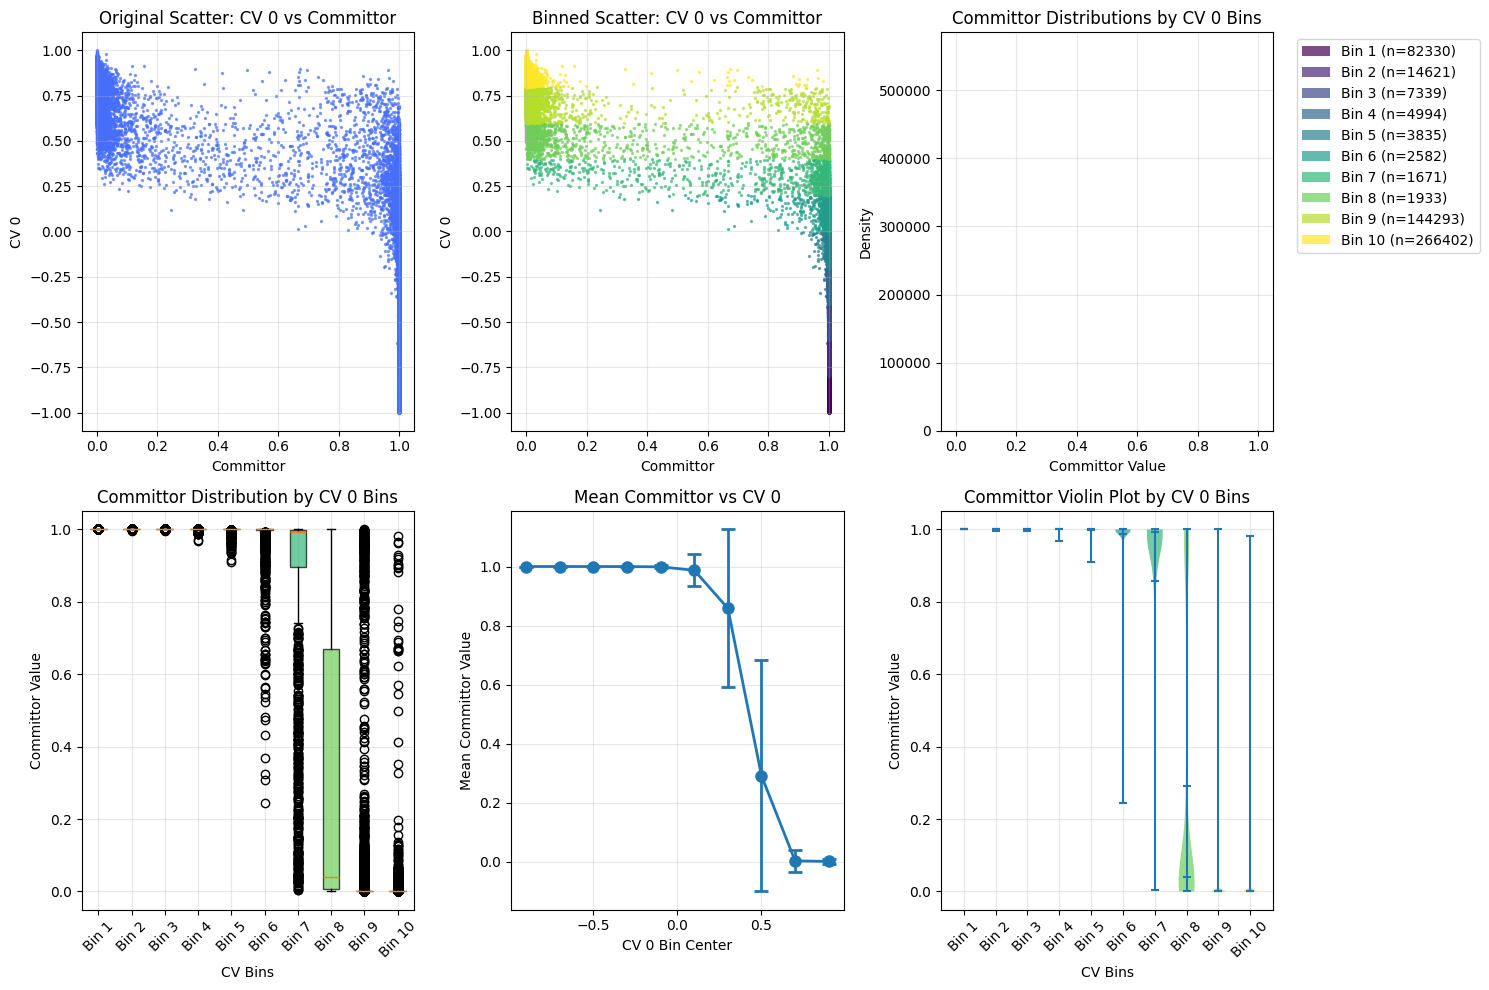


CV 0 Binning Statistics:
Bin 1: CV range [-1.00, -0.80]
  Points: 82330
  Committor mean: 1.0000 ± 0.0000
  Committor median: 1.0000

Bin 2: CV range [-0.80, -0.60]
  Points: 14621
  Committor mean: 1.0000 ± 0.0000
  Committor median: 1.0000

Bin 3: CV range [-0.60, -0.40]
  Points: 7339
  Committor mean: 1.0000 ± 0.0001
  Committor median: 1.0000

Bin 4: CV range [-0.40, -0.20]
  Points: 4994
  Committor mean: 0.9998 ± 0.0010
  Committor median: 1.0000

Bin 5: CV range [-0.20, 0.00]
  Points: 3835
  Committor mean: 0.9990 ± 0.0048
  Committor median: 1.0000

Bin 6: CV range [0.00, 0.20]
  Points: 2582
  Committor mean: 0.9872 ± 0.0548
  Committor median: 0.9996

Bin 7: CV range [0.20, 0.40]
  Points: 1671
  Committor mean: 0.8581 ± 0.2679
  Committor median: 0.9926

Bin 8: CV range [0.40, 0.60]
  Points: 1933
  Committor mean: 0.2908 ± 0.3920
  Committor median: 0.0395

Bin 9: CV range [0.60, 0.80]
  Points: 144293
  Committor mean: 0.0024 ± 0.0361
  Committor median: 0.0004

Bin 10:

In [38]:
# Binned CV analysis with committor distributions
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Parameters for binning
n_bins = 10  # Number of CV bins
alpha = 0.7  # Transparency for histograms

for cv_dim in range(MLCV_DIM):
    cv_values = cv[:, cv_dim]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # Original scatter plot
    ax1 = plt.subplot(2, 3, 1)
    scatter = ax1.scatter(committor_value, cv_values, color=blue, s=2, alpha=0.6)
    ax1.set_xlabel("Committor")
    ax1.set_ylabel(f"CV {cv_dim}")
    ax1.set_title(f"Original Scatter: CV {cv_dim} vs Committor")
    ax1.grid(True, alpha=0.3)
    
    # Bin the CV values
    cv_bins = np.linspace(cv_values.min(), cv_values.max(), n_bins + 1)
    cv_bin_centers = (cv_bins[:-1] + cv_bins[1:]) / 2
    cv_bin_indices = np.digitize(cv_values, cv_bins) - 1
    cv_bin_indices = np.clip(cv_bin_indices, 0, n_bins - 1)  # Ensure indices are in valid range
    
    # Create color map for bins
    colors = plt.cm.viridis(np.linspace(0, 1, n_bins))
    
    # Plot 1: Binned scatter plot with colors
    ax2 = plt.subplot(2, 3, 2)
    for i in range(n_bins):
        mask = cv_bin_indices == i
        if np.sum(mask) > 0:
            ax2.scatter(committor_value[mask], cv_values[mask], 
                       color=colors[i], s=2, alpha=0.6, 
                       label=f'Bin {i+1}: [{cv_bins[i]:.2f}, {cv_bins[i+1]:.2f}]')
    ax2.set_xlabel("Committor")
    ax2.set_ylabel(f"CV {cv_dim}")
    ax2.set_title(f"Binned Scatter: CV {cv_dim} vs Committor")
    ax2.grid(True, alpha=0.3)
    
    # Plot 2: Committor distributions for each CV bin
    ax3 = plt.subplot(2, 3, 3)
    bin_stats = []
    
    for i in range(n_bins):
        mask = cv_bin_indices == i
        if np.sum(mask) > 10:  # Only plot if we have enough points
            committor_subset = committor_value[mask]
            ax3.hist(committor_subset, bins=30, alpha=alpha, color=colors[i],
                    label=f'Bin {i+1} (n={np.sum(mask)})', density=True)
            
            # Store statistics
            bin_stats.append({
                'bin': i+1,
                'cv_range': f'[{cv_bins[i]:.2f}, {cv_bins[i+1]:.2f}]',
                'n_points': np.sum(mask),
                'committor_mean': np.mean(committor_subset),
                'committor_std': np.std(committor_subset),
                'committor_median': np.median(committor_subset)
            })
    
    ax3.set_xlabel("Committor Value")
    ax3.set_ylabel("Density")
    ax3.set_title(f"Committor Distributions by CV {cv_dim} Bins")
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Plot 3: Box plot of committor values by CV bins
    ax4 = plt.subplot(2, 3, 4)
    committor_by_bin = []
    bin_labels = []
    
    for i in range(n_bins):
        mask = cv_bin_indices == i
        if np.sum(mask) > 10:
            committor_by_bin.append(committor_value[mask])
            bin_labels.append(f'Bin {i+1}')
    
    if committor_by_bin:
        bp = ax4.boxplot(committor_by_bin, labels=bin_labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(committor_by_bin)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax4.set_xlabel("CV Bins")
    ax4.set_ylabel("Committor Value")
    ax4.set_title(f"Committor Distribution by CV {cv_dim} Bins")
    ax4.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Plot 4: Mean committor vs CV bin center
    ax5 = plt.subplot(2, 3, 5)
    if bin_stats:
        bin_centers_used = []
        mean_committors = []
        std_committors = []
        
        for i, stat in enumerate(bin_stats):
            bin_idx = stat['bin'] - 1
            bin_centers_used.append(cv_bin_centers[bin_idx])
            mean_committors.append(stat['committor_mean'])
            std_committors.append(stat['committor_std'])
        
        ax5.errorbar(bin_centers_used, mean_committors, yerr=std_committors,
                    marker='o', capsize=5, capthick=2, linewidth=2, markersize=8)
        ax5.set_xlabel(f"CV {cv_dim} Bin Center")
        ax5.set_ylabel("Mean Committor Value")
        ax5.set_title(f"Mean Committor vs CV {cv_dim}")
        ax5.grid(True, alpha=0.3)
    
    # Plot 5: Violin plot
    ax6 = plt.subplot(2, 3, 6)
    if committor_by_bin:
        vp = ax6.violinplot(committor_by_bin, positions=range(1, len(committor_by_bin) + 1),
                           showmeans=True, showmedians=True)
        
        for i, pc in enumerate(vp['bodies']):
            if i < len(colors):
                pc.set_facecolor(colors[i])
                pc.set_alpha(0.7)
    
    ax6.set_xlabel("CV Bins")
    ax6.set_ylabel("Committor Value")
    ax6.set_title(f"Committor Violin Plot by CV {cv_dim} Bins")
    ax6.set_xticks(range(1, len(bin_labels) + 1))
    ax6.set_xticklabels(bin_labels, rotation=45)
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nCV {cv_dim} Binning Statistics:")
    print("=" * 60)
    if bin_stats:
        for stat in bin_stats:
            print(f"Bin {stat['bin']}: CV range {stat['cv_range']}")
            print(f"  Points: {stat['n_points']}")
            print(f"  Committor mean: {stat['committor_mean']:.4f} ± {stat['committor_std']:.4f}")
            print(f"  Committor median: {stat['committor_median']:.4f}")
            print()
        
        # Compute statistical tests between bins
        print("Statistical Tests (Mann-Whitney U test between adjacent bins):")
        print("-" * 40)
        for i in range(len(bin_stats) - 1):
            bin1_mask = cv_bin_indices == (bin_stats[i]['bin'] - 1)
            bin2_mask = cv_bin_indices == (bin_stats[i+1]['bin'] - 1)
            
            if np.sum(bin1_mask) > 10 and np.sum(bin2_mask) > 10:
                statistic, p_value = stats.mannwhitneyu(
                    committor_value[bin1_mask], 
                    committor_value[bin2_mask],
                    alternative='two-sided'
                )
                print(f"Bin {bin_stats[i]['bin']} vs Bin {bin_stats[i+1]['bin']}: p = {p_value:.2e}")
    print()


## Folded state RMSD and CVs

In [25]:
rmsd_to_folded_state_path = f"/home/shpark/prj-mlcv/lib/DESRES/dataset/{molecule}-all/folded_state_rmsd_ca.pt"
rmsd_to_folded_state = torch.load(rmsd_to_folded_state_path).numpy()
print(rmsd_to_folded_state.shape)
print(cv.shape)

# for cv_dim in range(MLCV_DIM):
# 	fig = plt.figure(figsize=(7, 6))
# 	ax = fig.add_subplot(111)
# 	ax.scatter(rmsd_to_folded_state, cv[:, cv_dim], color=blue, s=2)
# 	ax.set_xlabel("Committor")
# 	ax.set_ylabel(f"CV {cv_dim}")
# 	ax.set_title(f"CV {cv_dim} vs Committor")
# 	plt.show()

(1044000,)
(530000, 1)


# Conclusion